## 1. Đọc data set RFM

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


file_path = "/content/drive/MyDrive/DA_Unigap/Python/RFM_Project/ecommerce retail.xlsx"
ecommerce_retail = pd.read_excel(file_path, sheet_name="ecommerce retail")
segmentation = pd.read_excel(file_path, sheet_name="Segmentation")


# 2.EDA

In [3]:
# Reomove Description vì thấy ko liên quan đến cái mình phân tích là RFM
df = ecommerce_retail.drop('Description', axis=1)
df


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
541904,581587,22613,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# Xác định khách hàng có data
df['Identifine_Cus'] = df['CustomerID'].notna()
df

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Identifine_Cus
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,True
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,True
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
...,...,...,...,...,...,...,...,...
541904,581587,22613,12,2011-12-09 12:50:00,0.85,12680.0,France,True
541905,581587,22899,6,2011-12-09 12:50:00,2.10,12680.0,France,True
541906,581587,23254,4,2011-12-09 12:50:00,4.15,12680.0,France,True
541907,581587,23255,4,2011-12-09 12:50:00,4.15,12680.0,France,True


In [5]:
#Gán đơn hủy -> ko tính là Total Price
df['Cancelled_InvoiceNo'] = df['InvoiceNo'].astype(str).str.startswith('C')

In [6]:
# Gán quốc gia: UK hay other
df['is_UK'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'Other')

In [7]:
# Tính TotalPrice nhưng ko tính đơn hủy và đơn hủy sẽ có revenue = 0
df['Total_Price'] = np.where(df['Cancelled_InvoiceNo'], 0, df['Quantity'] * df['UnitPrice'])

## 3. Tính Recency - Frequency - Monetary

In [8]:

ref_date = pd.to_datetime('2011-12-31') #Ngày tính của chỉ số R tính vào ngày 31/12/2011

rfm = (df.groupby('CustomerID')
          .agg({
          'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
          'InvoiceNo'  : 'nunique',                            # Frequency (gồm cả hủy)
          'Total_Price': 'sum'                                 # Monetary (đơn hủy đã = 0)
}).reset_index())

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo'  : 'Frequency',
                    'Total_Price': 'Monetary'}, inplace=True)

In [9]:
# Kết quả sau khi tính Recency - Frequency - Monetary
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,346,2,77183.60
1,12347.0,23,7,4310.00
2,12348.0,96,4,1797.24
3,12349.0,39,1,1757.55
4,12350.0,331,1,334.40
...,...,...,...,...
4367,18280.0,298,1,180.60
4368,18281.0,201,1,80.82
4369,18282.0,28,3,178.05
4370,18283.0,24,16,2094.88


# 4. Nhóm danh sách tất cả khách hàng (gồm cả khách không có data)

In [10]:

all_customers = df[['CustomerID', 'Identifine_Cus', 'is_UK']].drop_duplicates()

rfm_full = pd.merge(all_customers, rfm, on='CustomerID', how='left')

# Gán mặc định cho khách chưa có dữ liệu
rfm_full[['Recency', 'Frequency', 'Monetary']] = rfm_full[['Recency', 'Frequency', 'Monetary']].fillna(9999) #nếu khách hàng chưa từng có gd, thì tạm gán là 9999 và tránh pd.qcut()


#  5. Tính điểm R, F, M (từ 1–5)

In [11]:

# Recency nhỏ -> điểm cao
# Dùng qcut() để chia dữ liệu thành các nhóm bằng nhau về số lượng phần tử "chia theo phân vị (quantile cut)"
rfm_full['R_Score'] = pd.qcut(rfm_full['Recency'], 5, labels=[5,4,3,2,1]).astype(int)

# Frequency & Monetary lớn -> điểm cao
rfm_full['F_Score'] = pd.qcut(rfm_full['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm_full['M_Score'] = pd.qcut(rfm_full['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

## 6. Tạo mã RFM theo thứ tự Frequency–Recency–Monetary

In [12]:

rfm_full['RFM_Score'] = (
    rfm_full['F_Score'].astype(str) +
    rfm_full['R_Score'].astype(str) +
    rfm_full['M_Score'].astype(str)
)

## 7. Đối chiếu với sheet 2 là segmentation

In [13]:

segment_dict = {}
for i, row in segmentation.iterrows():
    scores = str(row['RFM Score']).replace(' ', '').split(',')
    for s in scores:
        segment_dict[s.strip()] = row['Segment'] # kiểm tra và xuất ra điểm RFM tương ứng từ bản chuẩn Segmentation

rfm_full['Segment'] = rfm_full['RFM_Score'].map(segment_dict).fillna('Unclassified')

## 8. Xuất file kết quả

In [14]:

rfm_full.to_excel("RFM_Segmentation_Result.xlsx", index=False)
print("RFM_Segmentation_Result.xlsx đã được tạo thành công!")

RFM_Segmentation_Result.xlsx đã được tạo thành công!


In [15]:
rfm_full

,CustomerID,Identifine_Cus,is_UK,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,17850.0,True,UK,323.0,35.0,5391.21,1,5,5,515,Promising
1,13047.0,True,UK,52.0,18.0,3237.54,4,5,5,545,Champions
2,12583.0,True,Other,23.0,18.0,7281.38,5,5,5,555,Champions
3,13748.0,True,UK,116.0,5.0,948.25,2,4,4,424,Promising
4,15100.0,True,UK,351.0,6.0,876.00,1,4,3,413,Promising
...,...,...,...,...,...,...,...,...,...,...,...
4369,13436.0,True,UK,22.0,1.0,196.89,5,2,1,251,About To Sleep
4370,15520.0,True,UK,22.0,1.0,343.50,5,2,2,252,At Risk
4371,13298.0,True,UK,22.0,1.0,360.00,5,2,2,252,At Risk
4372,14569.0,True,UK,22.0,1.0,227.39,5,2,1,251,About To Sleep


## 9. Visulization


# Thể hiện Customer có data và ko có data

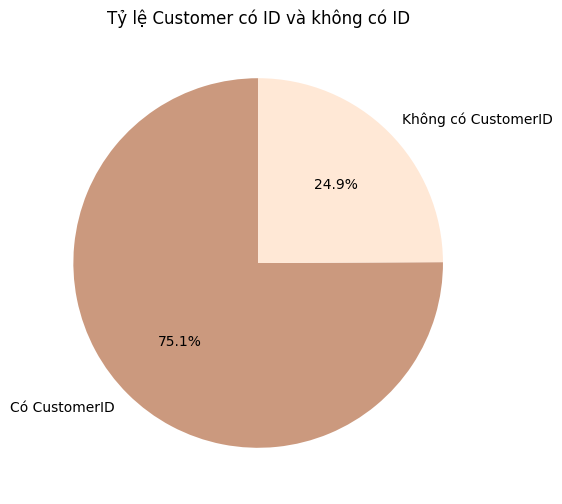

In [16]:

customer_counts = df['Identifine_Cus'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(customer_counts, labels=['Có CustomerID', 'Không có CustomerID'], autopct='%1.1f%%', startangle=90, colors=['#cb997e','#ffe8d6'])
plt.title('Tỷ lệ Customer có ID và không có ID')
plt.show()

## Thể hiện % Country của United Kingdom và other

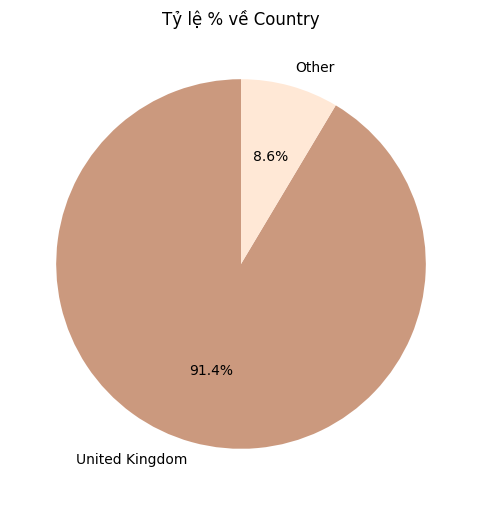

In [17]:
country_counts = df['is_UK'].value_counts()


plt.figure(figsize=(6,6))
plt.pie(country_counts, labels=['United Kingdom', 'Other'], autopct='%1.1f%%', startangle=90, colors=['#cb997e','#ffe8d6'])
plt.title('Tỷ lệ % về Country')
plt.show()

# Tính revenue của đơn bị cancel

Tổng doanh thu từ đơn hủy: £896812.49
Tổng doanh thu chung: £9747747.93
Phần trăm doanh thu từ đơn hủy: 9.20%


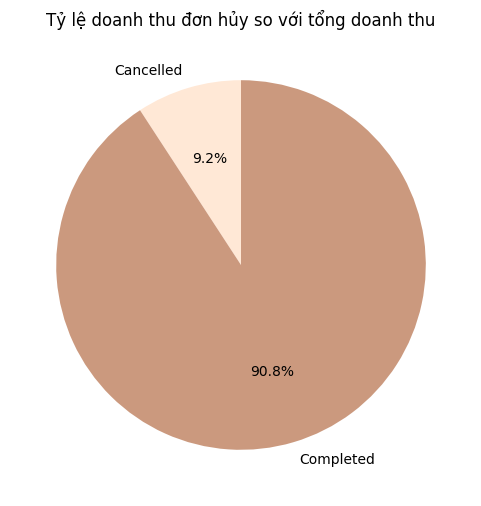

In [18]:
# Tổng doanh thu tất cả invoices (lấy giá trị dương)
total_revenue = abs((df['Quantity'] * df['UnitPrice']).sum())

# Tổng doanh thu từ đơn hủy (dương)
revenue_cancelled = abs((df.loc[df['Cancelled_InvoiceNo'], 'Quantity'] * df.loc[df['Cancelled_InvoiceNo'], 'UnitPrice']).sum())

# Doanh thu còn lại
revenue_completed = total_revenue - revenue_cancelled

# Tỷ lệ %
percent_cancelled = round(revenue_cancelled / total_revenue * 100, 2)

print(f"Tổng doanh thu từ đơn hủy: £{revenue_cancelled:.2f}")
print(f"Tổng doanh thu chung: £{total_revenue:.2f}")
print(f"Phần trăm doanh thu từ đơn hủy: {percent_cancelled:.2f}%")

#Visualization

plt.figure(figsize=(6,6))
plt.pie([revenue_cancelled, revenue_completed],
        labels=['Cancelled','Completed'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ffe8d6','#cb997e'])
plt.title('Tỷ lệ doanh thu đơn hủy so với tổng doanh thu')
plt.show()


# Customer Segments by RFM Model

/tmp/ipython-input-3389088912.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


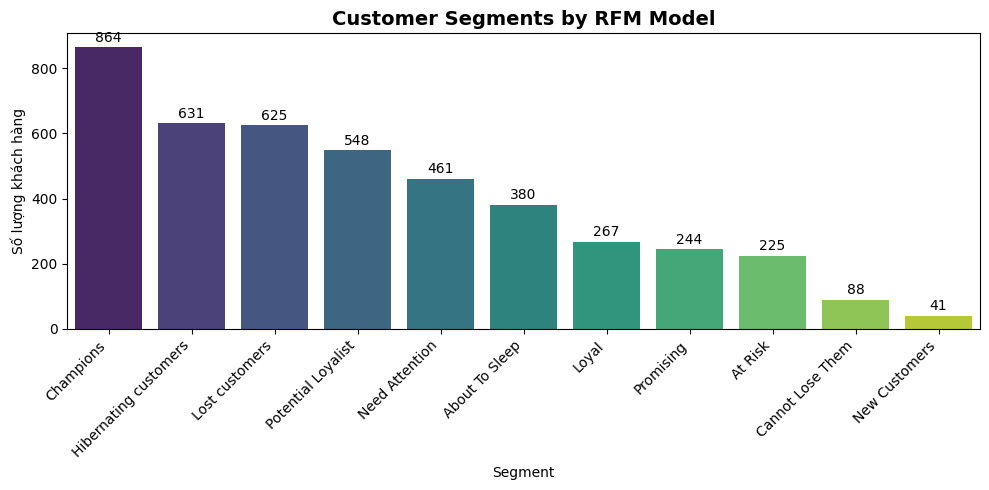

In [19]:
plt.figure(figsize=(10,5))
ax = sns.countplot(
    data=rfm_full,
    x='Segment',
    order=rfm_full['Segment'].value_counts().index,
    palette='viridis'
)

# Hiển thị nhãn số trên mỗi cột
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2) # định dạng dạng int - đặt label ở trên - khoảng cách giữa các cột là 2

plt.xticks(rotation=45, ha='right') # xoay nhãn 45 độ và căn phải
plt.title('Customer Segments by RFM Model', fontsize=14, weight='bold')
plt.xlabel('Segment')
plt.ylabel('Số lượng khách hàng')
plt.tight_layout() # tự động chỉnh layout
plt.show()


In [20]:
df_has_id = rfm_full[rfm_full['CustomerID'].notna()]
df_no_id   = rfm_full[rfm_full['CustomerID'].isna()]


In [21]:
rfm_full.groupby('Segment')[['Recency','Frequency','Monetary']].mean().sort_values('Monetary', ascending=False)


,Recency,Frequency,Monetary
Segment,,,
Champions,31.077546,14.420139,6567.906736
Loyal,45.546816,4.176030,2432.801948
Promising,251.180328,87.877049,2397.046766
Need Attention,68.069414,5.451193,1892.403080
Cannot Lose Them,291.113636,1.227273,1823.862841
At Risk,62.204444,1.360000,876.840267
Potential Loyalist,66.912409,3.293796,575.842887
Hibernating customers,141.591125,1.664025,411.564090
New Customers,196.146341,4.243902,309.325122


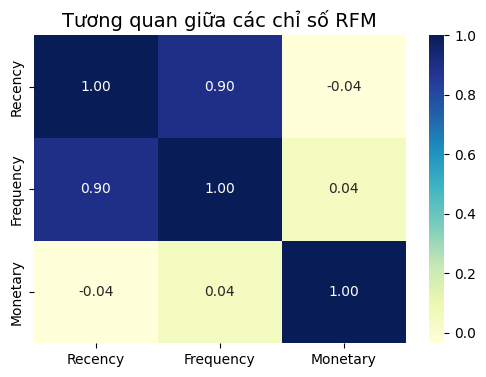

In [22]:

rfm_corr = rfm_full[['Recency', 'Frequency', 'Monetary']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(rfm_corr, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Tương quan giữa các chỉ số RFM', fontsize=14)
plt.show()

/tmp/ipython-input-1705160226.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


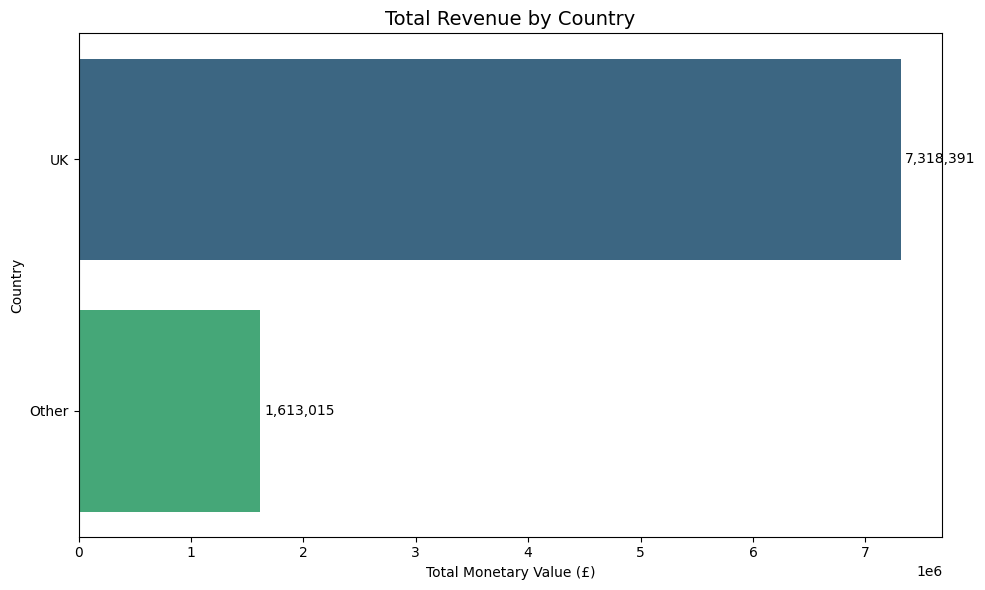

In [23]:
plt.figure(figsize=(10,6))

country_sales = (
    rfm_full.groupby('is_UK')['Monetary']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

ax = sns.barplot(
    data=country_sales,
    x='Monetary',
    y='is_UK',
    palette='viridis'
)

plt.title('Total Revenue by Country', fontsize=14)
plt.xlabel('Total Monetary Value (£)')
plt.ylabel('Country')

for container in ax.containers:
    labels = [f"{x:,.0f}" for x in container.datavalues]  # làm tròn và có dấu phẩy ngăn cách hàng nghìn
    ax.bar_label(container, labels=labels, label_type='edge', fontsize=10, padding=3)

plt.tight_layout()
plt.show()
